In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re
pd.set_option('display.max_columns', None)  # Alle Spalten anzeigen

In [2]:
data_arr = pd.read_csv("zhaw_export_arrivals.csv", delimiter=';')

C:\Users\janni\AppData\Local\Temp\ipykernel_24196\1719746789.py:1: DtypeWarning: Columns (3,4,14,15,16,17,18,25,26,27,28,29,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  data_arr = pd.read_csv("zhaw_export_arrivals.csv", delimiter=';')


In [3]:
data_dep = pd.read_csv("zhaw_export_departures.csv", delimiter=';')

C:\Users\janni\AppData\Local\Temp\ipykernel_24196\527424227.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data_dep = pd.read_csv("zhaw_export_departures.csv", delimiter=';')


In [4]:
data = pd.concat([data_arr, data_dep], ignore_index=True)
data['actual_landing_time_utc'] = pd.to_datetime(data['actual_landing_time_utc'], errors='coerce')
data['actual_take_off_time_utc'] = pd.to_datetime(data['actual_take_off_time_utc'], errors='coerce')

# Neue Spalte mit der ersten vorhandenen (nicht-NaT) Zeit pro Zeile
data['all_times'] = data[['actual_landing_time_utc', 'actual_take_off_time_utc']].min(axis=1)
data = data.sort_values(by=['all_times']).reset_index(drop=True)


In [5]:
data.head(25)

,flight_identifier,flight_repeat_count,scheduled_flight_date_utc,actual_in_block_time_utc,actual_landing_time_utc,aircraft_category_icao_code,aircraft_registration,aircraft_seat_capacity,aircraft_type_icao_code,connecting_passenger_count,delay_irregularity_code_1,delay_irregularity_code_2,delay_irregularity_code_3,delay_irregularity_code_4,estimated_in_block_time_1_utc,estimated_in_block_time_2_utc,estimated_in_block_time_3_utc,estimated_in_block_time_4_utc,estimated_in_block_time_5_utc,estimated_taxi_in_time,flight_category,flight_number,flight_route_origin_airport_iata_code,handling_agent_passengers,instrumental_or_visual_flight_rule,irregularity_code_1,irregularity_code_2,irregularity_code_3,irregularity_code_4,flight_cancelled_or_diverted,flight_is_general_aviation,local_passenger_count,scheduled_in_block_time_utc,tarmac_parking_position,total_passenger_count,runway_concept,runway,movement_type,actual_off_block_time_utc,actual_take_off_time_utc,begin_taxi_time_utc,begin_calculated_take_off_time_utc,end_calculated_take_off_time_utc,estimated_off_block_time_1_utc,estimated_off_block_time_2_utc,estimated_off_block_time_3_utc,estimated_taxi_out_time,flight_route_destination_airport_iata_code,maximum_take_off_weight,minimum_turnaround_time,scheduled_off_block_time_utc,standard_instrument_departure_route,all_times
0,LX087,0,01.01.2023,01.01.2023 06:04,2023-01-01 06:00:00,E,HBJHI,236.0,A333,145.0,3.0,NaN,NaN,NaN,01.01.2023 06:08,01.01.2023 06:08,01.01.2023 06:08,01.01.2023 06:06,01.01.2023 06:06,6.0,10,87,YUL,UNK,I,3,NaN,NaN,NaN,NaN,FALSCH,53.0,01.01.2023 06:15,E47,198.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:00:00
1,AC6820,0,01.01.2023,01.01.2023 06:04,2023-01-01 06:00:00,E,HBJHI,236.0,A333,NaN,3.0,NaN,NaN,NaN,01.01.2023 06:08,01.01.2023 06:08,01.01.2023 06:08,01.01.2023 06:06,01.01.2023 06:06,6.0,10,6820,YUL,UNK,I,3,NaN,NaN,NaN,NaN,FALSCH,NaN,01.01.2023 06:15,E47,199.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:00:00
2,LX139,0,01.01.2023,01.01.2023 06:06,2023-01-01 06:02:00,E,HBJMI,223.0,A343,175.0,NaN,NaN,NaN,NaN,NaN,01.01.2023 06:05,01.01.2023 06:07,01.01.2023 06:09,01.01.2023 06:09,6.0,10,139,HKG,UNK,I,NaN,NaN,NaN,NaN,NaN,FALSCH,28.0,01.01.2023 06:10,E20,203.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:02:00
3,CX6633,0,01.01.2023,01.01.2023 06:06,2023-01-01 06:02:00,E,HBJMI,223.0,A343,NaN,NaN,NaN,NaN,NaN,NaN,01.01.2023 06:05,01.01.2023 06:07,01.01.2023 06:09,01.01.2023 06:09,6.0,10,6633,HKG,UNK,I,NaN,NaN,NaN,NaN,NaN,FALSCH,NaN,01.01.2023 06:10,E20,203.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:02:00
4,UA9731,0,01.01.2023,01.01.2023 06:08,2023-01-01 06:04:00,E,HBJNL,320.0,B77W,NaN,10.0,NaN,NaN,NaN,01.01.2023 06:11,01.01.2023 06:08,01.01.2023 06:09,01.01.2023 06:11,01.01.2023 06:10,6.0,10,9731,DXB,UNK,I,88A,NaN,NaN,NaN,NaN,FALSCH,NaN,01.01.2023 06:10,E26,286.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:04:00
5,LX243,0,01.01.2023,01.01.2023 06:08,2023-01-01 06:04:00,E,HBJNL,320.0,B77W,231.0,10.0,NaN,NaN,NaN,01.01.2023 06:11,01.01.2023 06:08,01.01.2023 06:09,01.01.2023 06:11,01.01.2023 06:10,6.0,10,243,DXB,UNK,I,88A,NaN,NaN,NaN,NaN,FALSCH,55.0,01.01.2023 06:10,E26,286.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:04:00
6,AC6799,0,01.01.2023,01.01.2023 06:08,2023-01-01 06:04:00,E,HBJNL,320.0,B77W,NaN,10.0,NaN,NaN,NaN,01.01.2023 06:11,01.01.2023 06:08,01.01.2023 06:09,01.01.2023 06:11,01.01.2023 06:10,6.0,10,6799,DXB,UNK,I,88A,NaN,NaN,NaN,NaN,FALSCH,NaN,01.01.2023 06:10,E26,286.0,Evening_C1,14.0,Arrival,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-01-01 06:04:00
7,LX283,0,01.01.2023,01.01.2023 06:10,2023-01-01 06:06:00,E,HBJMC,223.0,A343,170.0,NaN,NaN,NaN,NaN,01.01.2023 06:06,01.01.2023 06:14,01.01.2023 06:13,

## Doppelte Flüge entfernen

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# ================================
# 1) Pfade & Zeitraum
# ================================
P_ARR   = Path("zhaw_export_arrivals.csv")
P_DEP   = Path("zhaw_export_departures.csv")
P_METAR = Path("metar_combined_HALBHOUR_20230101_0550_to_20250912_2320.csv")

OUT_FLIGHTS = Path("flights_per_interval_HALBHOUR_20230101_0550_to_20250912_2320.csv")

TIME_START = pd.Timestamp("2023-01-01 05:50")
TIME_STOP  = pd.Timestamp("2025-09-12 23:20")

# ================================
# 2) Helper-Funktionen
# ================================
def read_semicolon_csv(p: Path):
    df = pd.read_csv(p, sep=";", encoding="utf-8", low_memory=False)
    if df.shape[1] == 1:
        df = pd.read_csv(p, sep=";", encoding="latin1", low_memory=False)
    df.columns = df.columns.str.strip().str.lower()
    return df

def parse_time_col(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    return pd.to_datetime(s, dayfirst=True, errors="coerce")

def get_interval_start(t: pd.Timestamp) -> pd.Timestamp:
    """xx:20–xx:49 → :20, xx:50–xx:59 → :50, xx:00–xx:19 → vorige Stunde :50."""
    if pd.isna(t):
        return pd.NaT
    m = t.minute
    if 20 <= m < 50:
        return t.replace(minute=20, second=0, microsecond=0)
    elif m >= 50:
        return t.replace(minute=50, second=0, microsecond=0)
    else:
        return (t - pd.Timedelta(hours=1)).replace(minute=50, second=0, microsecond=0)

# ================================
# 3) METAR-Raster laden (Halbstunde, lückenlos)
# ================================
metar = pd.read_csv(P_METAR, encoding="utf-8")
if "time" not in metar.columns:
    raise ValueError("In der METAR-Datei fehlt die Spalte 'time'.")

metar["time"] = pd.to_datetime(metar["time"], errors="coerce", utc=True).dt.tz_convert("UTC").dt.tz_localize(None)
metar = metar[(metar["time"] >= TIME_START) & (metar["time"] <= TIME_STOP)]
grid = metar["time"].dropna().drop_duplicates().sort_values()

# ================================
# 4) Arrivals & Departures laden
# ================================
arr = read_semicolon_csv(P_ARR)
dep = read_semicolon_csv(P_DEP)

req_arr = "actual_landing_time_utc"
req_dep = "actual_take_off_time_utc"
if req_arr not in arr.columns:
    raise ValueError(f"In den Arrivals fehlt '{req_arr}'. Vorhanden: {list(arr.columns)[:10]} ...")
if req_dep not in dep.columns:
    raise ValueError(f"In den Departures fehlt '{req_dep}'. Vorhanden: {list(dep.columns)[:10]} ...")

arr[req_arr] = parse_time_col(arr[req_arr])
dep[req_dep] = parse_time_col(dep[req_dep])

arr = arr[(arr[req_arr] >= TIME_START) & (arr[req_arr] <= TIME_STOP)].copy()
dep = dep[(dep[req_dep] >= TIME_START) & (dep[req_dep] <= TIME_STOP)].copy()

# ================================
# 5) Duplikate je Flugzeug & Intervall entfernen
# ================================
def dedup_by_aircraft(df: pd.DataFrame, time_col: str, label: str) -> pd.DataFrame:
    df = df.copy()
    df["interval_start"] = df[time_col].apply(get_interval_start)
    df["interval_end"] = df["interval_start"] + pd.Timedelta(minutes=30)

    # Falls Registration fehlt, ersatzweise nach flight_identifier gruppieren
    if "aircraft_registration" not in df.columns:
        df["aircraft_registration"] = df["flight_identifier"]

    before = len(df)
    df_unique = df.drop_duplicates(subset=["aircraft_registration", "interval_start"])
    removed = before - len(df_unique)
    if removed > 0:
        print(f"⚠️  {removed} doppelte Flüge entfernt (gleiche Registration im selben Intervall) [{label}]")

    # Count je Intervall = Anzahl eindeutiger Flugzeuge
    g = df_unique.groupby(["interval_start", "interval_end"], as_index=False).agg(**{label: ("aircraft_registration", "nunique")})
    return g

g_arr = dedup_by_aircraft(arr, req_arr, "n_arrivals")
g_dep = dedup_by_aircraft(dep, req_dep, "n_departures")

# ================================
# 6) Lückenloses Grid & Merge
# ================================
df_grid = pd.DataFrame({"interval_start": grid})
df_grid["interval_end"] = df_grid["interval_start"] + pd.Timedelta(minutes=30)

fpi = df_grid.merge(g_arr, on=["interval_start", "interval_end"], how="left")
fpi = fpi.merge(g_dep, on=["interval_start", "interval_end"], how="left")

fpi["n_arrivals"]   = fpi["n_arrivals"].fillna(0).astype(int)
fpi["n_departures"] = fpi["n_departures"].fillna(0).astype(int)
fpi["n_total"]      = fpi["n_arrivals"] + fpi["n_departures"]

fpi = fpi.sort_values("interval_start").reset_index(drop=True)

# ================================
# 7) Speichern & Diagnose
# ================================
fpi.to_csv(OUT_FLIGHTS, index=False, encoding="utf-8")

print("✅ flights_per_interval (Halbstundenraster, lückenlos) gespeichert:", OUT_FLIGHTS)
print(f"Zeilen: {len(fpi):,}  | Zeitraum: {fpi['interval_start'].min()} – {fpi['interval_start'].max()}")
print(f"Leere Intervalle (Nachtruhe etc.): {(fpi['n_total']==0).sum():,}")


⚠️  291690 doppelte Flüge entfernt (gleiche Registration im selben Intervall) [n_arrivals]
⚠️  303847 doppelte Flüge entfernt (gleiche Registration im selben Intervall) [n_departures]
✅ flights_per_interval (Halbstundenraster, lückenlos) gespeichert: flights_per_interval_HALBHOUR_20230101_0550_to_20250912_2320.csv
Zeilen: 47,316  | Zeitraum: 2023-01-01 05:50:00 – 2025-09-12 23:20:00
Leere Intervalle (Nachtruhe etc.): 12,021


## Darstellen der Movements im 30 Minuten Intervall (inkl. Nacht)

Plot gespeichert unter: distribution_total_flights_per_30min_interval.pdf


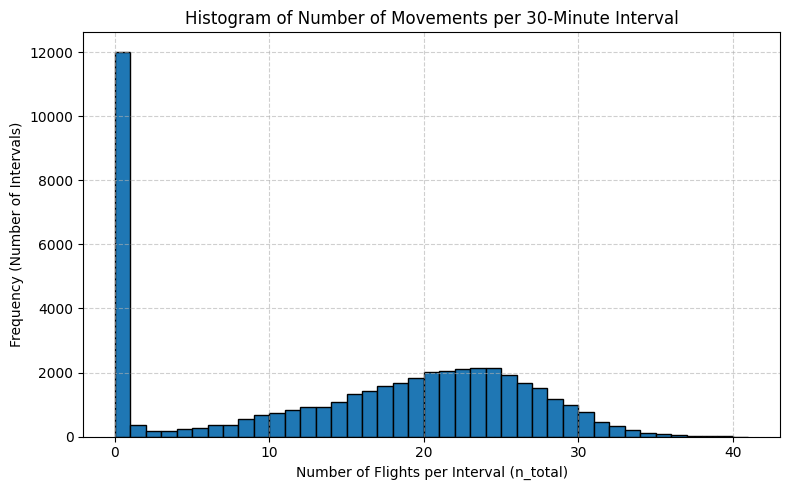

In [ ]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


path = Path("flights_per_interval_HALBHOUR_20230101_0550_to_20250912_2320.csv")

# CSV lesen
flights_per_interval = pd.read_csv(path)

# sicherstellen, dass n_total numerisch ist
flights_per_interval["n_total"] = pd.to_numeric(
    flights_per_interval["n_total"],
    errors="coerce"
).fillna(0).astype(int)


plt.figure(figsize=(8, 5))
plt.hist(
    flights_per_interval["n_total"],
    bins=range(0, flights_per_interval["n_total"].max() + 2),
    edgecolor="black"
)

plt.title("Histogram of Number of Movements per 30-Minute Interval")
plt.xlabel("Number of Flights per Interval (n_total)")
plt.ylabel("Frequency (Number of Intervals)")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()


plot_path = path.parent / "distribution_total_flights_per_30min_interval.pdf"
plt.savefig(plot_path, bbox_inches="tight")
print(f"Plot gespeichert unter: {plot_path}")

plt.show()


## MeteoSuisse und Flights merge

In [ ]:
# ======================================================
# 1) Pfade
# ======================================================
P_FLIGHTS = Path("flights_per_interval_HALBHOUR_20230101_0550_to_20250912_2320.csv")
P_METAR   = Path("metar_combined_HALBHOUR_20230101_0550_to_20250912_2320.csv")
P_OUTPUT  = Path("flights_with_meteosuisse_HALBHOUR_merged.csv")


# ======================================================
# 2) Grundeinstellungen
# ======================================================
GRID_START = pd.Timestamp("2023-01-01 05:50", tz="UTC")
MAKE_TZ_AWARE = True  # sicherstellen, dass alle Zeiten gleich behandelt werden

# ======================================================
# 3) Hilfsfunktionen
# ======================================================
def to_utc_naive(s: pd.Series) -> pd.Series:
    """Robust nach UTC normalisieren und TZ entfernen (naiv)."""
    x = pd.to_datetime(s, errors="coerce", utc=True)
    return x.dt.tz_convert("UTC").dt.tz_localize(None)

def snap_to_grid(ts: pd.Series, grid_start: pd.Timestamp) -> pd.Series:
    """Snap auf 30-Minuten-Raster ab grid_start (Floor)."""
    if isinstance(grid_start, pd.Timestamp) and grid_start.tz is not None:
        ts_aware = pd.to_datetime(ts, errors="coerce", utc=True)
        ts_naive = ts_aware.dt.tz_convert("UTC").dt.tz_localize(None)
        gs_naive = grid_start.tz_convert("UTC").tz_localize(None)
    else:
        ts_naive = pd.to_datetime(ts, errors="coerce")
        gs_naive = pd.Timestamp(grid_start)
    delta = ts_naive - gs_naive
    step = pd.Timedelta(minutes=30)
    floored = (delta // step) * step
    return gs_naive + floored

# ======================================================
# 4) Daten laden
# ======================================================
flights = pd.read_csv(P_FLIGHTS, encoding="utf-8")
metar   = pd.read_csv(P_METAR,   encoding="utf-8")

# ======================================================
# 5) Zeitspalten harmonisieren
# ======================================================
# METAR
metar["time"] = to_utc_naive(metar["time"])
metar["grid_time"] = snap_to_grid(metar["time"], GRID_START)

# Doppelte grid_time (z. B. mehrere Stationen) auf einen Eintrag reduzieren
if "station" in metar.columns:
    metar = (
        metar.sort_values(["grid_time", "station", "time"])
             .drop_duplicates(subset=["grid_time", "station"], keep="last")
    )
else:
    metar = (
        metar.sort_values(["grid_time", "time"])
             .drop_duplicates(subset=["grid_time"], keep="last")
    )

# FLIGHTS
flights["interval_start"] = to_utc_naive(flights["interval_start"])
flights["interval_end"]   = to_utc_naive(flights["interval_end"])
flights["grid_time"]      = snap_to_grid(flights["interval_start"], GRID_START)

# ======================================================
# 6) Merge auf grid_time 
# ======================================================
cols_metar_keep = [c for c in metar.columns if c not in {"time"}]
flights_with_metar = flights.merge(
    metar[cols_metar_keep],
    on="grid_time",
    how="left",
    suffixes=("", "_metar")
)

# ======================================================
# 7) Diagnose
# ======================================================
total_flights = len(flights)
merged_rows   = len(flights_with_metar)
metar_unique  = metar["grid_time"].nunique()
missing_metar = flights_with_metar.filter(regex="^(?!interval_|n_|grid_).*", axis=1).isna().all(axis=1).sum()

print("\n✅ Merge abgeschlossen")
print(f"Flights (Input):        {total_flights:,}")
print(f"Output (Rows):          {merged_rows:,}")
print(f"METAR grid_time unique: {metar_unique:,}")
print(f"Ungepaarte Intervals:   {missing_metar:,}")

# ======================================================
# 8) Speichern
# ======================================================
flights_with_metar.to_csv(P_OUTPUT, index=False, encoding="utf-8")
print(f"\n💾 Gespeichert als: {P_OUTPUT}")

# ======================================================
# 9) Vorschau
# ======================================================
print("\nVorschau (erste 5 Zeilen):")
print(flights_with_metar.head(5))


✅ Merge abgeschlossen
Flights (Input):        47,316
Output (Rows):          47,316
METAR grid_time unique: 47,316
Ungepaarte Intervals:   0

💾 Gespeichert als: flights_with_meteosuisse_HALBHOUR_merged.csv

Vorschau (erste 5 Zeilen):
       interval_start        interval_end  n_arrivals  n_departures  n_total  \
0 2023-01-01 05:50:00 2023-01-01 06:20:00           5             0        5   
1 2023-01-01 06:20:00 2023-01-01 06:50:00           1             3        4   
2 2023-01-01 06:50:00 2023-01-01 07:20:00           4             9       13   
3 2023-01-01 07:20:00 2023-01-01 07:50:00           1            18       19   
4 2023-01-01 07:50:00 2023-01-01 08:20:00           5             8       13   

            grid_time station  \
0 2023-01-01 05:50:00     KLO   
1 2023-01-01 06:20:00     KLO   
2 2023-01-01 06:50:00     KLO   
3 2023-01-01 07:20:00     KLO   
4 2023-01-01 07:50:00     KLO   

   air_temperature_2_m_above_ground_current_value_[degc]  \
0                        

In [12]:
import pandas as pd

df = pd.read_csv("flights_with_meteosuisse_HALBHOUR_merged.csv")
df


,interval_start,interval_end,n_arrivals,n_departures,n_total,grid_time,station,air_temperature_2_m_above_ground_current_value_[degc],air_temperature_at_5_cm_above_grass_current_value_[degc],air_temperature_at_surface_current_value_[degc],chill_temperature_current_value_[degc],relative_air_humidity_2_m_above_ground_current_value_[percent],dew_point_2_m_above_ground_current_value_[degc],vapour_pressure_2_m_above_ground_current_value_[hpa],atmospheric_pressure_at_barometric_altitude_(qfe)_current_value_[hpa],pressure_reduced_to_sea_level_according_to_standard_atmosphere_(qnh)_current_value_[hpa],pressure_reduced_to_sea_level_(qff)_current_value_[hpa],geopotential_height_of_the_850_hpa_level_current_value_[gpm],geopotential_height_of_the_700_hpa_level_current_value_[gpm],gust_peak_(one_second)_maximum_in_m_per_s_[m_per_s],wind_speed_vectoriel_ten_minutes_mean_in_m_per_s_[m_per_s],wind_speed_scalar_ten_minutes_mean_in_m_per_s_[m_per_s],wind_direction_ten_minutes_mean_[deg],foehn_index_[code],wind_speed_ten_minutes_mean_in_km_per_h_[km_per_h],gust_peak_(three_seconds)_maximum_in_m_per_s_[m_per_s],gust_peak_(one_second)_maximum_in_km_per_h_[km_per_h],gust_peak_(three_seconds)_maximum_in_km_per_h_[km_per_h],precipitation_ten_minutes_total_[mm],snow_depth_(automatic_measurement)_current_value_[cm],global_radiation_ten_minutes_mean_[w_per_m²],diffuse_radiation_ten_minutes_mean_[w_per_m²],longwave_incoming_radiation_ten_minutes_mean_[w_per_m²],longwave_outgoing_radiation_ten_minute_mean_[w_per_m²],shortwave_reflected_radiation_ten_minute_mean_[w_per_m²],sunshine_duration_ten_minutes_total_[min]
0,2023-01-01 05:50:00,2023-01-01 06:20:00,5,0,5,2023-01-01 05:50:00,KLO,13.0,9.9,9.1,13.0,66.3,6.9,9.9,973.0,1023.8,1023.5,NaN,NaN,7.3,4.0,4.1,224.0,NaN,14.8,6.9,26.3,24.8,0.0,0.0,2,1.0,302,NaN,NaN,0
1,2023-01-01 06:20:00,2023-01-01 06:50:00,1,3,4,2023-01-01 06:20:00,KLO,12.5,9.7,9.0,12.5,68.4,6.8,9.9,973.2,1024.0,1023.8,NaN,NaN,6.1,4.1,4.1,233.0,NaN,14.8,5.7,22.0,20.5,0.0,0.0,2,1.0,300,NaN,NaN,0
2,2023-01-01 06:50:00,2023-01-01 07:20:00,4,9,13,2023-01-01 06:50:00,KLO,13.1,10.8,10.1,13.1,65.4,6.8,9.9,973.2,1024.0,1023.7,NaN,NaN,9.3,6.2,6.3,231.0,NaN,22.7,9.1,33.5,32.8,0.0,0.0,1,0.0,300,NaN,NaN,0
3,2023-01-01 07:20:00,2023-01-01 07:50:00,1,18,19,2023-01-01 07:20:00,KLO,12.8,10.7,10.0,12.8,66.3,6.7,9.8,973.4,1024.2,1024.0,NaN,NaN,9.0,5.3,5.4,235.0,NaN,19.4,8.8,32.4,31.7,0.0,0.0,10,8.0,299,NaN,NaN,0
4,2023-01-01 07:50:00,2023-01-01 08:20:00,5,8,13,2023-01-01 07:50:00,KLO,13.4,12.3,11.7,13.4,64.0,6.7,9.8,973.7,1024.5,1024.2,NaN,NaN,12.7,7.2,7.3,228.0,NaN,26.3,12.2,45.7,43.9,0.0,0.0,40,25.0,300,NaN,NaN,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47311,2025-09-12 21:20:00,2025-09-12 21:50:00,15,9,24,2025-09-12 21:20:00,KLO,11.3,7.3,7.7,11.3,94.8,10.5,12.7,971.6,1022.3,1022.4,NaN,NaN,1.9,0.9,1.1,127.0,NaN,4.0,1.8,6.8,6.5,0.0,0.0,1,0.0,298,NaN,NaN,0
47312,2025-09-12 21:50:00,2025-09-12 22:20:00,12,12,24,2025-09-12 21:50:00,KLO,10.5,6.2,7.2,10.5,96.9,10.0,12.3,971.5,1022.2,1022.4,NaN,NaN,1.0,0.5,0.5,146.0,NaN,1.8,0.9,3.6,3.2,0.0,0.0,2,1.0,297,NaN,NaN,0
47313,2025-09-12 22:20:00,2025-09-12 22:50:00,13,5,18,2025-09-12 22:20:00,KLO,9.6,6.2,7.0,8.7,95.2,8.9,11.4,971.6,1022.3,1022.7,NaN,NaN,2.6,2.0,2.0,304.0,NaN,7.2,2.5,9.4,9.0,0.0,0.0,3,2.0,294,NaN,NaN,0
47314,2025-09-12 22:50:00,2025-09-12 23:20:00,4,6,10,2025-09-12 22:50:00,KLO,9.3,6.0,7.0,8.4,97.2,8.9,11.4,971.7,1022.4,1022.8,NaN,NaN,2.5,1.9,1.9,296.0,NaN,6.8,2.4,9.0,8.6,0.0,0.0,1,0.0,297,NaN,NaN,0
